# Predicting income level with US census data

# 1) Introduction

The goal of this case study is to predict which people save more or less than $50,000 / year, from the information contained in the US census dataset provided in the data folder.

#### Data description

Metadata is provided in the data folder

The data was split into train/test in approximately 2/3, 1/3 proportions.

Prediction task is to determine the income level for the person represented by the record.  Incomes have been binned at the $50K level to present a binary classification problem, much like the original UCI/ADULT database.  The goal field of this data, however, was drawn from the "total person income" field rather than the "adjusted gross income" and may, therefore, behave differently than the orginal ADULT goal field.

More information detailing the meaning of the attributes can be
found in http://www.bls.census.gov/cps/cpsmain.htm

# 2) Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from math import ceil

# 3) Load data

#### Load data into pandas dataframes

In [2]:
# Headers of csv are missing
columns_names = ["age", "class_of_worker", "industry_code", "occupation_code",
                "education", "wage_per_hour", "enroll_in_edu_inst", "marital_stat",
                "major_industry_code", "major_occupation_code", "race", "hispanic_origin", "sex",
                "member_labor", "reason_unemployment", "full_or_part", "capital_gains",
                 "capital_losses", "dividends", "tax_filler", "region_prev_residence",
                "state_prev_residence", "detailed_household_fam_stat", "detailed_household_summary",
                 "instance_weight", "migration_code_msa", "migration_code_reg", "migration_code_move_reg",
                "live_house", "migration_sunbelt", "num_persons_worked_employers", "fam_members_u18", "birth_father",
                 "birth_mother", "birth_self", "citizenship", "own_or_self", "vet_admin", "vet_benef",
                 "weeks_worked_year", "year", "income"]
len(columns_names)

42

In [3]:
# Replace "?" by nan values
data_train = pd.read_csv("data/census_income_learn.csv", names=columns_names, na_values="?", sep=r'\s*,\s*')
data_test = pd.read_csv("data/census_income_test.csv", names=columns_names, na_values="?", sep=r'\s*,\s*')

In [4]:
print("The training set contains {} features and {} rows. The testing set contains {} rows.".format(
        data_train.shape[1], data_train.shape[0], data_test.shape[0]))

The training set contains 42 features and 199523 rows. The testing set contains 99762 rows.


#### Create a single dataframe from the 2 files for data cleaning

In [5]:
data = data_train
data = data.append(data_test).reset_index(drop=False)
data = data.drop(["instance_weight","index"], axis=1)
data.tail()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enroll_in_edu_inst,marital_stat,major_industry_code,major_occupation_code,...,birth_father,birth_mother,birth_self,citizenship,own_or_self,vet_admin,vet_benef,weeks_worked_year,year,income
299280,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
299281,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
299282,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
299283,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
299284,67,Not in universe,0,0,9th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,94,- 50000.


#### Convert types

Some features are encoded as integers, like `industry code` but do not present any ordering. 

We want to convert the types of those cells, that are `int` by default, into an `object` type to get categorical data.

In [6]:
types_to_change = ["industry_code", "occupation_code", "own_or_self", "year"]

In [7]:
for t in types_to_change:
    data[t] = data[t].astype("object")

In [8]:
data.dtypes

age                              int64
class_of_worker                 object
industry_code                   object
occupation_code                 object
education                       object
wage_per_hour                    int64
enroll_in_edu_inst              object
marital_stat                    object
major_industry_code             object
major_occupation_code           object
race                            object
hispanic_origin                 object
sex                             object
member_labor                    object
reason_unemployment             object
full_or_part                    object
capital_gains                    int64
capital_losses                   int64
dividends                        int64
tax_filler                      object
region_prev_residence           object
state_prev_residence            object
detailed_household_fam_stat     object
detailed_household_summary      object
migration_code_msa              object
migration_code_reg       

# 4) Exploratory analysis (part 1)

#### Variables distribution

We can plot the distribution of each feature separately to get a better understanding of our dataset.

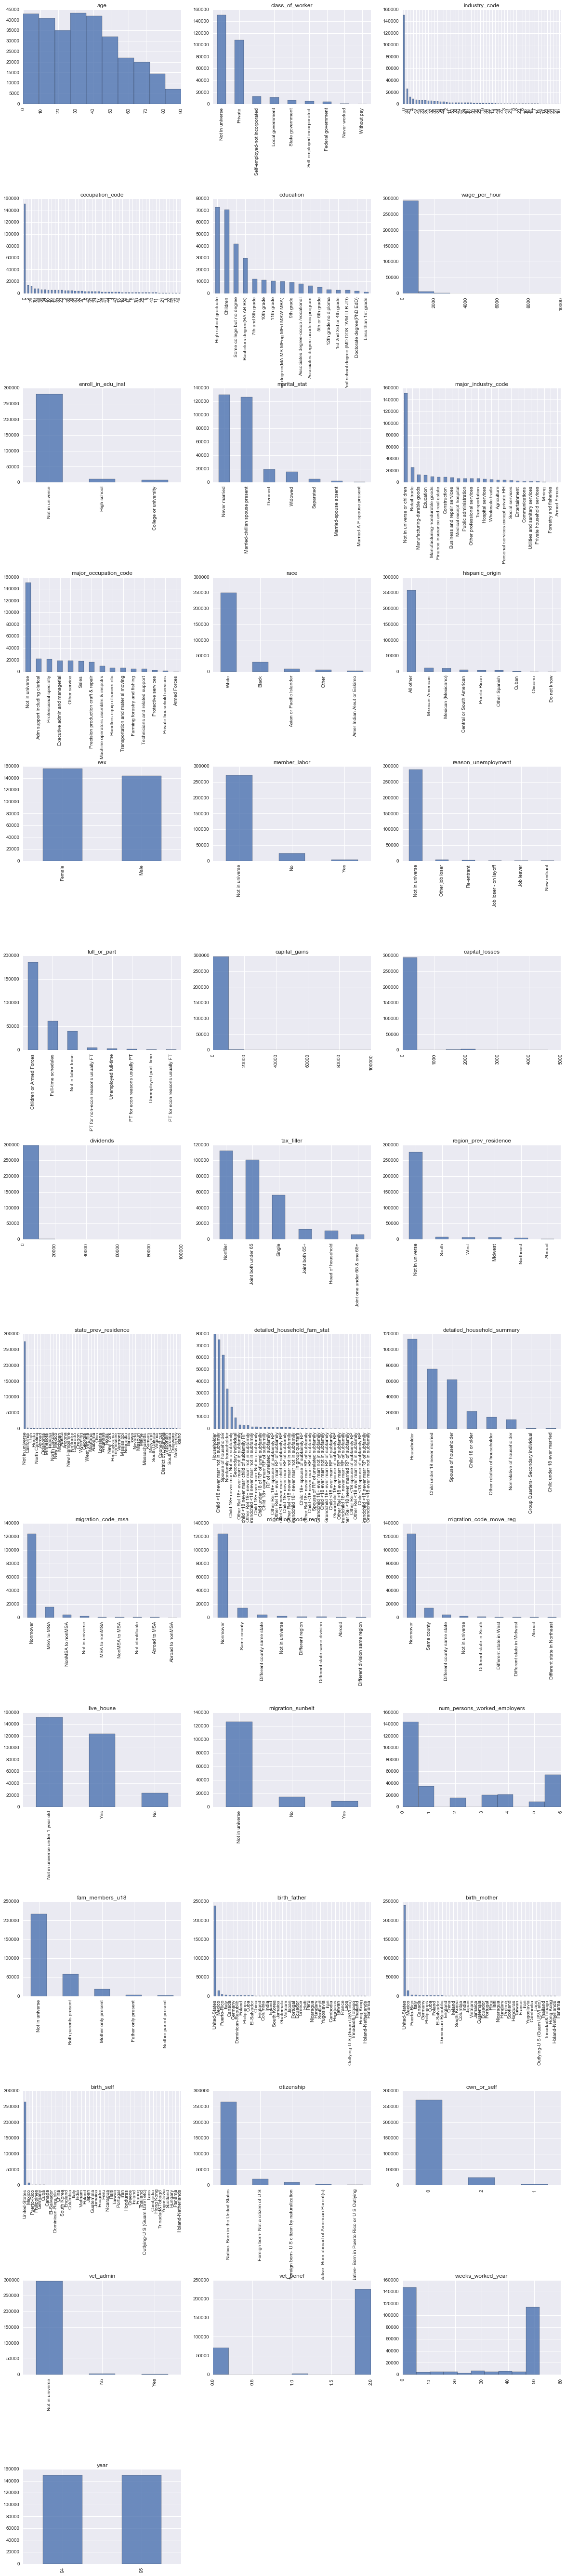

In [9]:
fig = plt.figure(figsize=(20,95))
cols = 3
rows = ceil(float(data.shape[1]) / cols)
for i, column in enumerate(data.drop(["income"], axis=1).columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    # Check if categorical data
    if data.dtypes[column] == np.object:
        data[column].value_counts().plot(kind="bar", axes=ax,
                                         alpha=0.8, color=sns.color_palette(n_colors=1))
    else:
        data[column].hist(axes=ax, alpha=0.8)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1, wspace=0.2)

**IMPORTANT:** This visualization above shows the distribution of the values in the dataset but doesn't show the distribution of the values in the real population! 

Indeed, this dataset has been constructed by stratified sampling. Each row represents a small category of the American population. The size of the category is shown in the `instance_weight` column. To visualize the "real" distribution, we woud have to consider each row `instance_weight` times. This is not the goal of this study.

#### Missing values

Let's see how many missing values we have per feature.

In [10]:
# Return the number of missing values for a given column
nb_missing = lambda column: len(np.where(data[column].isnull())[0])

In [11]:
col = []
nb_values = []
for column in data.drop(["income"], axis=1).columns:
    if nb_missing(column) !=0:
        nb_values.append(nb_missing(column)*100/float(len(data)))
        col.append(column)
list(zip(col, nb_values))

[('hispanic_origin', 0.42735185525502445),
 ('state_prev_residence', 0.3468266034047814),
 ('migration_code_msa', 49.99983293516214),
 ('migration_code_reg', 49.99983293516214),
 ('migration_code_move_reg', 49.99983293516214),
 ('migration_sunbelt', 49.99983293516214),
 ('birth_father', 3.3887431712247524),
 ('birth_mother', 3.070985849608233),
 ('birth_self', 1.723106737724911)]

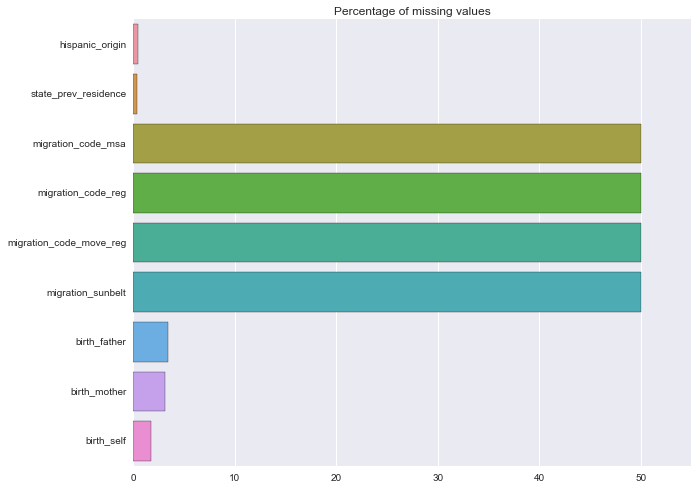

In [12]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x=nb_values, y=col)
ax.set_xlim(0,55)
plt.title("Percentage of missing values")

Most of the missing values are accounted by four variable concerning the immigration.

In [13]:
print(len(np.where(data[data["year"]==94]["migration_sunbelt"].isnull())[0]),
len(np.where(data[data["year"]==95]["migration_sunbelt"].isnull())[0]))

0 149642


We can see here that those missing values appeared in year 1995 only. We can safely assume that the question disappeared from the survey in 1995. Data imputation on 50% of the dataset would not make sense so we decide to drop those 4 columns.

Furthermore, an other group of variables contains a smal proportion of missing values: `hispanic_origin`, `state_prev_residence`, `birth_father`, `birth_mother`, `birth_self`.

Due to the small proportion of missingness, we'll chose to drop the rows containing missing values instead of replacing them by the mean or the mode of each column which could have a negative impact on the performance of the predictive model.

In [14]:
# Drop migration columns
data = data.drop(["migration_code_msa", "migration_code_reg", "migration_code_move_reg", "migration_sunbelt"], axis=1)

#### Extreme values

The extreme values are observed for the features concerning the capital and dividends: `capital_gains`, `capital_losses`, `dividends`. The huge majority of people represented in this dataset do not have any dividends or capital gains from stock.

Also we can notice some incoherences: several rows present a capital income* greater than \$50k and still are in the lower \$50k bracket.

*The capital income is the sum of the capital gains and dividends minus the capital losses.

In [15]:
# Create a new feature called capital_income
data["capital_income"] = data["capital_gains"] + data["dividends"] - data["capital_losses"]

In [16]:
def check_wrong(row):
    """Check if the capital_income is incoherent with the bracket"""
    try:
        return row["capital_income"] > 50000 and row["income"] == '- 50000.'
    except: # In case we have Nans we haven't dropped yet.
        return False

data["wrong_bracket"] = data.apply(lambda row: check_wrong(row), axis=1)

In [17]:
data["wrong_bracket"].value_counts()

False    299218
True         67
Name: wrong_bracket, dtype: int64

We have exactly 67 rows with the incoherence described above.

In [18]:
data = data.drop(["wrong_bracket"], axis=1)

# 5) Exploratory analysis (part 2)

In this second part, I want to explore the correlation between the different features of our dataset.

That way, we can maybe find some columns to delete or find trends to speculate the most important features for our classifier. Generally it is not a good sign to have correlated features.

For that, we first need to encode our categorical features as integers using the `LabelEncoder`from ScikiyLearn. We'll create a function `features_encoder` that return an encoded dataframe. We chose that process over the dummy variables because the latter will introduce a lot of new dimensions.

In [19]:
def features_encoder(df):
    """Takes a pandas.Dataframe as an argument and returns a pandas.Dataframe of only integers values"""
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

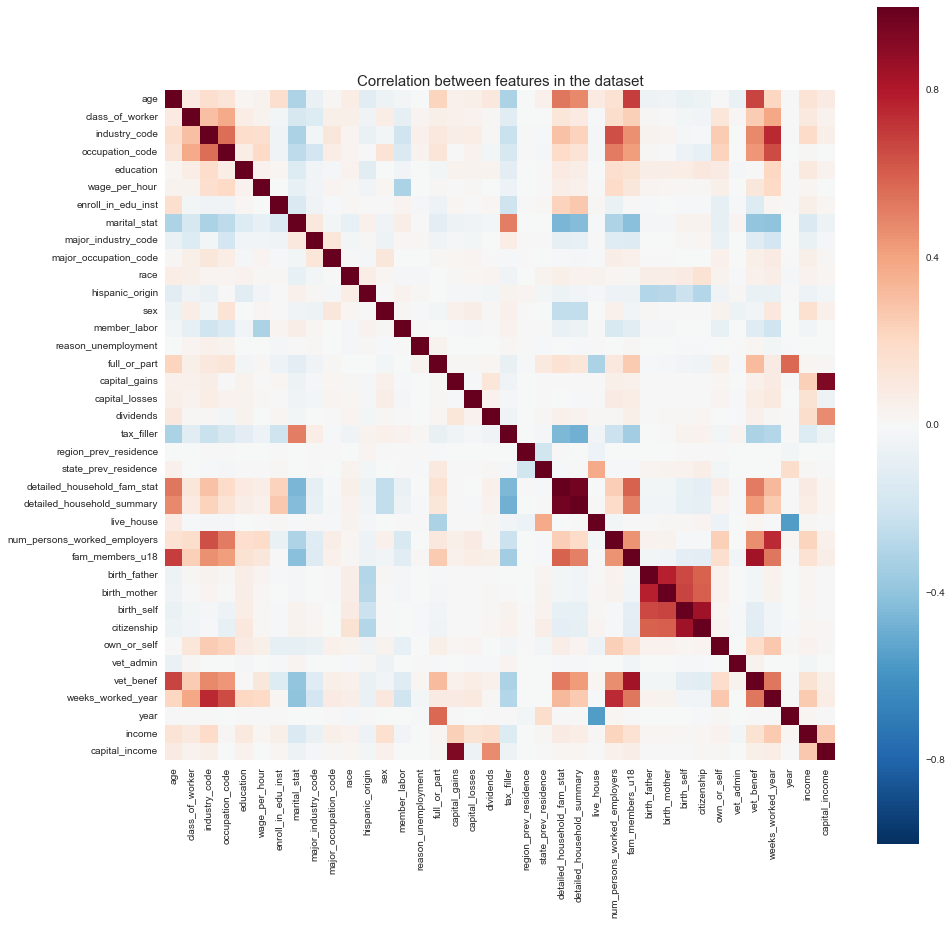

In [20]:
plt.figure(figsize=(15,15))
encoded_data, _ = features_encoder(data.dropna())
sns.heatmap(encoded_data.corr(), square=True)
plt.title("Correlation between features in the dataset", fontsize=15)

This visualization has a lot to tell.

#### Type of jobs

The variables `class_of_worker`, `industry_code` and `occupation_code` look quite correlated between each other. It's normal because they all describe the activity of those polled. Simple features like the first one are usually pefered in classification models so we decide to drop the other two.

In [21]:
data = data.drop(["industry_code", "occupation_code"], axis=1)

#### Family details

`detailed_household_fam_stat` and `detailed_household_summary` appear very correlated. Let's have a look at those columns:

In [22]:
data[["detailed_household_fam_stat", "detailed_household_summary"]][:10]

,detailed_household_fam_stat,detailed_household_summary
0,Other Rel 18+ ever marr not in subfamily,Other relative of householder
1,Householder,Householder
2,Child 18+ never marr Not in a subfamily,Child 18 or older
3,Child <18 never marr not in subfamily,Child under 18 never married
4,Child <18 never marr not in subfamily,Child under 18 never married
5,Spouse of householder,Spouse of householder
6,Householder,Householder
7,Secondary individual,Nonrelative of householder
8,Spouse of householder,Spouse of householder
9,Householder,Householder


The stat column looks more detailed than the summary. For the same reason than above, we chose to keep only the summary for the classifier.

In [23]:
data = data.drop("detailed_household_fam_stat", axis=1)

Same with the variable `fam_members_u18` that is already included in the detailed household summary.

In [24]:
data = data.drop("fam_members_u18", axis=1)

#### Place of birth

The place of birth of the parents and the person polled along with his citizenship are highly correlated. That makes totally sense given that the large majority of those polled are American. However, we can't really drop a column because of the cases where we have non US citizenship which could have an impact on the income.

#### Year

I can't explain why the Year is correlated with some variables in the dataset, like `live_house`. If we want to avoid overfitting we need to drop that column.

In [25]:
data = data.drop("year", axis=1)

We could obviously keep going with feature engineering but we will stop there for this analysis.

# 6) Build models

**NOTE:** Before detailing the process, note than the dataset is extremely unbalanced with almost 94% of incomes lesser than \$50k. To correct that, we should use an oversampling technique to counterbalance that skewness and improve the performances of the model. We won't do that in this analysis i norder to keep it relatively short.

**PROCESS:** <br>
- Feature selection using a quick and dirty Random Forest Classifier using the `features_encoder` function. <br>
- Binarization of the relevant features by creating dummy variables. <br>
- Logistic Regression.
- Random Forest classifier.
- Results interpretation

## 6.0) Splitting the data

We separate again the training and testing set for this last part.

In [26]:
data_train = data[:199523].dropna()
data_test = data[199523:].dropna()

## 6.1) Feature selection

Let's use the out of the box RF classifier from sk-learn for the features selection.

In [27]:
# Encode the data like for the heatmap.
encoded_train, _ = features_encoder(data_train)
encoded_test, _ = features_encoder(data_test)

In [28]:
# Separate the data and the target
X_train, y_train = encoded_train[encoded_train.columns - ["income"]], encoded_train["income"]
X_test, y_test = encoded_test[encoded_test.columns - ["income"]], encoded_test["income"]

In [29]:
# Initialize the model with 50 trees
RF = RandomForestClassifier(n_estimators=50, criterion="gini")

In [30]:
# Fit the model
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

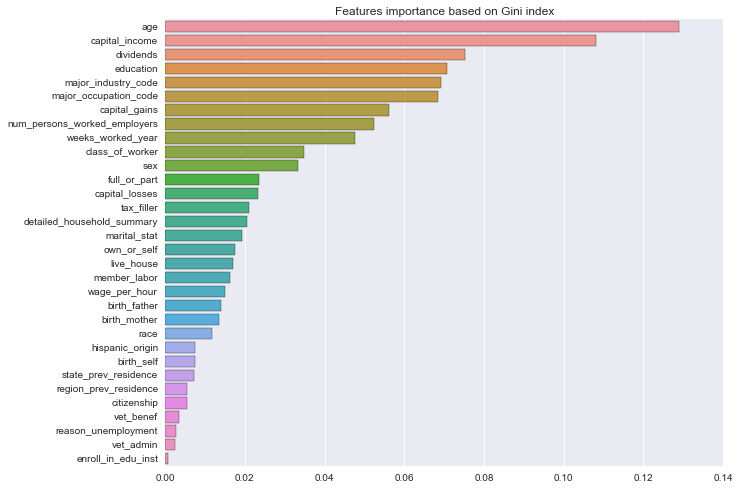

In [31]:
# Plot feature importance
x, y = zip(*sorted(list(zip(RF.feature_importances_, X_train.columns)), reverse=True))

plt.figure(figsize=(10,8))
plt.title("Features importance based on Gini index")
sns.barplot(x=x, y=y)

The feature importance is calculated with the Gini impurity index, as specified in the parameters of the classifier.

Surprisingly, the education is only on 4th position. This can be explained by the fact that the encoding of the features with our function is to simplistic and doesn't take into account the "ranking" in the levels of the `education` variable. It does play a major role in the income though, people with higher degrees earning, in average, more money.

Secondly, the variable `capital_income` we created during the feature engineering process appears to be very important as it combined 3 other columns into a single one.

Also, we can notice that `sex` has a non-negligeable importance in the model even if it is not a priori related with work experience. It appears indeed that men earn significantly more money that women — this was even truer in the 90’s.

Finally, we can see that the industry and occupation codes play a big role in the income level. That obviously makes sense given that someone working in the finance industry will have a higher income.

**Remark:** The Gini method is not the best for this kind of dataset (but the fastest, and we already get relevant results). Indeed, it is biased towards the categorical variables with a lot of levels like `major_industry_code`. A better way would be to use a sequential feature selection algorithm like the Sequential Backward Selection (which is not implemented in Python libraries I know).

In [32]:
# Define important variables to keep for the next models
imp_variables = ["age", "capital_income", "major_industry_code", 'education', 'major_occupation_code',
                 'num_persons_worked_employers', 'weeks_worked_year', 'class_of_worker', 'sex', 'dividends',
                 'capital_gains', 'income']

#### Performances of that 'dirty' model

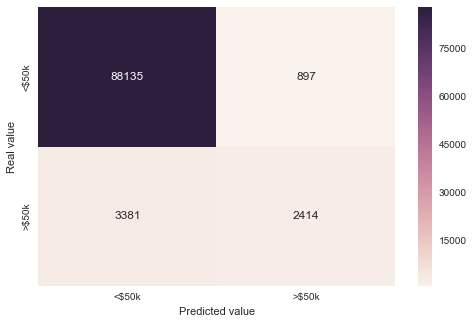

In [33]:
y_pred = RF.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["<$50k", ">$50k"], yticklabels=["<$50k", ">$50k"])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [34]:
print ("F1 score: %f" % metrics.f1_score(y_test, y_pred))
print ("Accuracy score: %f" % metrics.accuracy_score(y_test, y_pred))
print ("Precision score: %f" % metrics.precision_score(y_test, y_pred))
print ("Recall score: %f" % metrics.recall_score(y_test, y_pred))

F1 score: 0.530200
Accuracy score: 0.954886
Precision score: 0.729085
Recall score: 0.416566


We have a high accuracy score but a very low recall score denoting a large amount of false negatives. So what can we do better? <br>
- Use only the subset of relevant features we identified. <br>
- Binarization of the variables instead of encoding them with integers. Indeed, our current approach for encoding our data has the drawback that we put arbitrary order in our classes. And there is no order in the relationship status. <br>
- Use of grid search to optimize the parameters.

## 6.2) Binarization

In [35]:
# Keep only the important variables
data_train = data_train[imp_variables]
data_test = data_test[imp_variables]

In [36]:
# Get dummies create new binary variables. We drop the two correlated ones
data_train = pd.get_dummies(data_train).drop(["sex_Male", "income_- 50000."], axis=1)
data_test = pd.get_dummies(data_test).drop(["sex_Male", "income_- 50000."], axis=1)

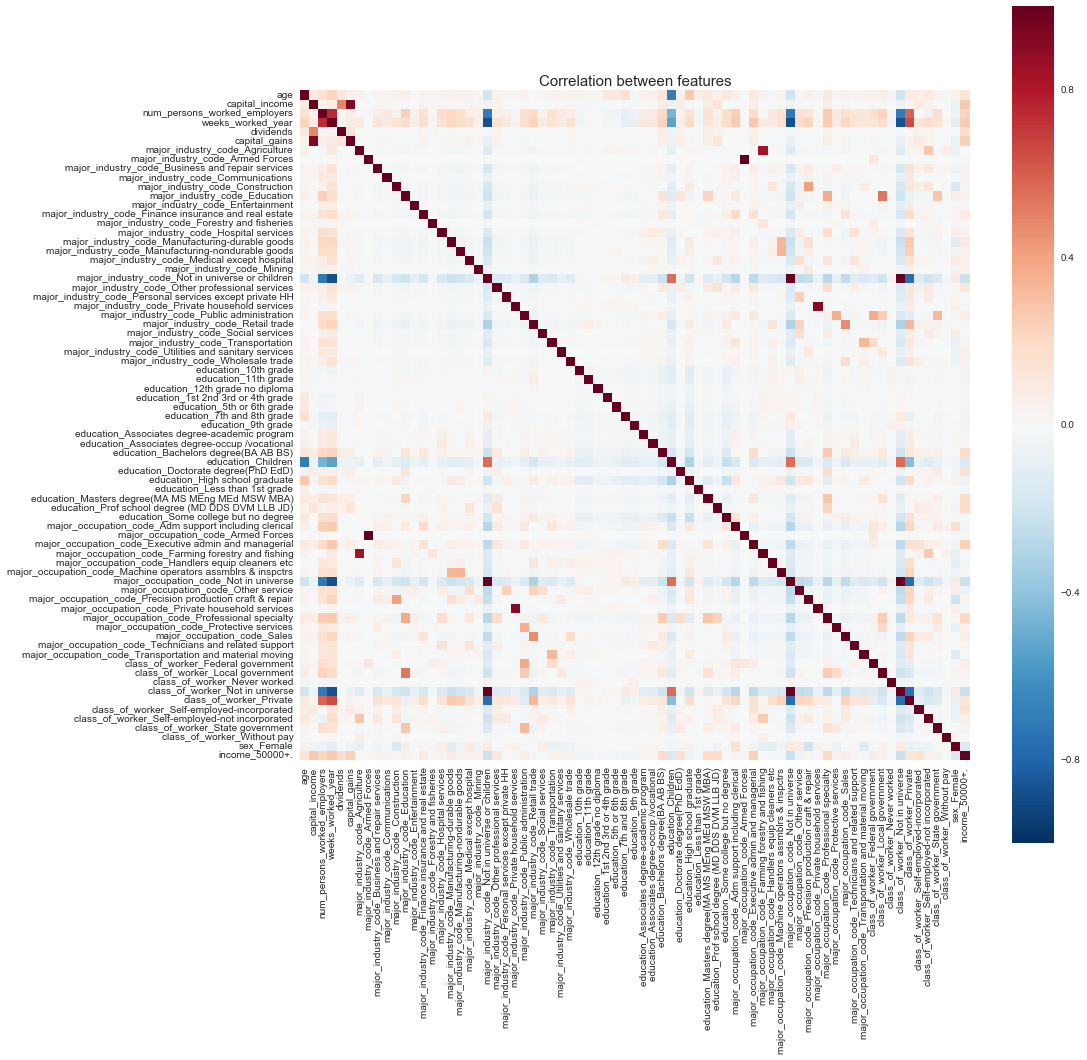

In [37]:
plt.figure(figsize=(15,15))
sns.heatmap(data_train.corr(), square=True)
plt.title("Correlation between features", fontsize=15)

On this figure we can easily visualize the conclusions we drew from the important features graph. I won't comment this figure much, it is extremely explicit and we already said a lot above.

In [38]:
X_train, y_train = data_train[data_train.columns - ['income_50000+.']], data_train['income_50000+.']
X_test, y_test = data_test[data_test.columns - ['income_50000+.']], data_test['income_50000+.']

# 6.3) Random Forest

To build that random forest, we will use grid search to optimize the hyper parameters of the model.

In [39]:
# Define the range of values we want to test
param_grid_RF = {'min_samples_split': np.arange(1,3),
              'min_samples_leaf' : np.arange(1, 3),
              'n_estimators' : np.arange(20, 50, 4)}

In [40]:
np.set_printoptions(suppress=True)
print(param_grid_RF)

{'min_samples_split': array([1, 2]), 'min_samples_leaf': array([1, 2]), 'n_estimators': array([20, 24, 28, 32, 36, 40, 44, 48])}


In [41]:
# Initialize the model with 3-folds cross-val
grid_search_RF = GridSearchCV(RandomForestClassifier(), param_grid_RF, verbose=1, cv=3)

In [42]:
# Fit the model
grid_search_RF.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  8.9min finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([1, 2]), 'min_samples_leaf': array([1, 2]), 'n_estimators': array([20, 24, 28, 32, 36, 40, 44, 48])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [43]:
# Best parameters
grid_search_RF.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 36}

#### Performances

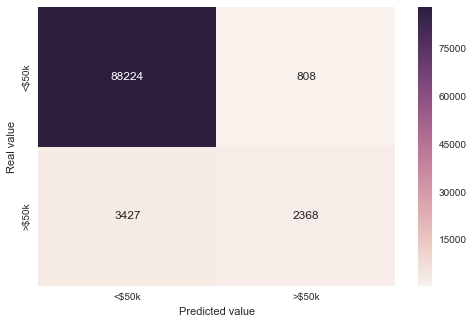

In [44]:
y_pred = grid_search_RF.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["<$50k", ">$50k"], yticklabels=["<$50k", ">$50k"])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [45]:
print ("F1 score: %f" % metrics.f1_score(y_test, y_pred))
print ("Accuracy score: %f" % metrics.accuracy_score(y_test, y_pred))
print ("Precision score: %f" % metrics.precision_score(y_test, y_pred))
print ("Recall score: %f" % metrics.recall_score(y_test, y_pred))

F1 score: 0.527923
Accuracy score: 0.955340
Precision score: 0.745592
Recall score: 0.408628


Very surprisingly, the new model doesn't perform better than the first we tried. We just traded some recall for precision and that's it. The binarization didn't improve the model at all, even if it didn't introduce an arbitrary order in the data.

Let's try logistic regression

# 6.4) Logistic regression

We proceed exactly the same way as for the Random Forest part.

In [46]:
# Define the range of values we want to test.
# We can only play with the regularization strength.
param_grid_LR = {'C': 10. ** np.arange(-3, 3)}

In [47]:
np.set_printoptions(suppress=True)
print(param_grid_LR)

{'C': array([   0.001,    0.01 ,    0.1  ,    1.   ,   10.   ,  100.   ])}


In [48]:
# Initialize the model with 3-folds cross-val
grid_search_LR = GridSearchCV(LogisticRegression(), param_grid_LR, verbose=1, cv=3)

In [49]:
# Fit the model
grid_search_LR.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   38.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([   0.001,    0.01 ,    0.1  ,    1.   ,   10.   ,  100.   ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [50]:
# Best parameters
grid_search_LR.best_params_

{'C': 1.0}

#### Performances

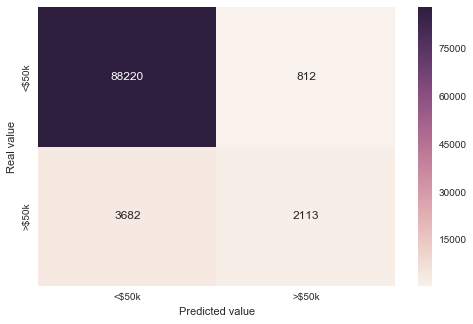

In [51]:
y_pred = grid_search_LR.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["<$50k", ">$50k"], yticklabels=["<$50k", ">$50k"])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [52]:
print ("F1 score: %f" % metrics.f1_score(y_test, y_pred))
print ("Accuracy score: %f" % metrics.accuracy_score(y_test, y_pred))
print ("Precision score: %f" % metrics.precision_score(y_test, y_pred))
print ("Recall score: %f" % metrics.recall_score(y_test, y_pred))

F1 score: 0.484633
Accuracy score: 0.952608
Precision score: 0.722393
Recall score: 0.364625


Logistic regression perform slightly worse than the random forest on the testing set so we'll stick with the random forest classifier.

# 7) Conclusion and remarks

This dataset is rich and we could spend a lot more time on the analysis. For the purpose of the exercise, I tried to keep it quite concise. If I had more time I would focus on several points to get better predictions: <br>
- First and foremost I would like to know if there is a reason to the incoherence I mentionned in part 4. I am really confused by the fact that some people can have a capital income greater than 50k and still be in the lower bracket. I didn't take the liberty to correct that because there may be a good reason but I am sure that it biased the model. <br>
- Using a real feature selection method instead of the biased one I used could also increase the performance. <br>
- And an oversampling method. <br>
- Imputing the missing values with matrix factorization or Multiple Imputation using Chained Equations. <br>
- Ensembling methods could also help to increse the precision and recall score.